In [106]:
%pylab inline
import GPyOpt
import GPy
import random

Populating the interactive namespace from numpy and matplotlib


In [188]:
# from GPyOpt.core.task import SingleObjective

class SingleObjectiveMD(GPyOpt.core.task.SingleObjective):

    def __init__(self,func,num_cores=1,objective_name='no_name',batch_type='synchronous',unfold_args=False,space=None):
        super(SingleObjectiveMD, self).__init__(func,num_cores,objective_name,batch_type,unfold_args,space)
        
    def _eval_func(self, x):
        """
        Performs sequential evaluations of the function at x (single location or batch). The computing time of each 
        evaluation is also provided.
        """
        cost_evals = []
        f_evals     = np.empty(shape=[1, 2])
        
        for i in range(x.shape[0]):
            st_time    = time.time()
            if self.unfold_args:
                args_indices = self.space.get_variable_indices()
                args = [x[i,args_indices[j,0]:args_indices[j,1]] for j in range(args_indices.shape[0])]
                rlt = self.func(*args)
            else:
                rlt = self.func(np.atleast_2d(x[i]))
            f_evals     = np.vstack([f_evals,rlt])
            cost_evals += [time.time()-st_time]  
        return f_evals, cost_evals 
    
class BOMD(GPyOpt.methods.ModularBayesianOptimization):
    def __init__(self,model, space, objective, acquisition, evaluator, X_init, Y_init=None, cost = None, normalize_Y = True, model_update_interval = 1):
        super(BOMD, self).__init__(model, space, objective, acquisition, evaluator, X_init, Y_init, cost, normalize_Y, model_update_interval)    
    
    def _compute_results(self):
        """
        Computes the optimum and its value.
        """
        self.Y_best = best_value(self.Y)
        self.x_opt = self.X[np.argmin(self.Y),:]
        self.fx_opt = min(self.Y[:,1])


In [208]:
(2 % 10)*2.0

4.0

In [219]:
initial_sample_sz = 10

from GPyOpt.util.general import reshape
import time

# func  = GPyOpt.objective_examples.experiments2d.branin()
def func(X):
    X = reshape(X,5)
    n = X.shape[0]
    fval = np.array([[0.0,0.0]])
    return fval.reshape(n,2)

objective = SingleObjectiveMD(func)
space_bounds = [{'name': 'var_' + str(idx+1), 'type': 'continuous', 'domain': (l,h)}
          for idx, (l,h) in enumerate(zip([1,1,1,1,1],[3,3,3,3,3]))]
space = GPyOpt.Design_space(space=space_bounds)

# kernel = 
gp_model = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False,normalize_Y=False)

aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space, fast=True, n_samples=1000, maxiter=10)
initial_design = GPyOpt.util.stats.initial_design('random', space, 10)
acquisition = AcquisitionMasked(gp_model, space, optimizer=aquisition_optimizer)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
bo = BOMD(gp_model, space, objective, acquisition, evaluator, initial_design)

max_iter  = 2
bo.run_optimization(max_iter = max_iter, eps=-1)
bo.plot_acquisition()

AttributeError: 'NoneType' object has no attribute 'X'

In [148]:
func  = GPyOpt.objective_examples.experiments2d.branin()
objective = GPyOpt.core.task.SingleObjective(func.f)
space = GPyOpt.Design_space(space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-7,10)},
                                    {'name': 'var_2', 'type': 'continuous', 'domain': (1,15)}])
model = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)

aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space, fast=True, n_samples=1000, maxiter=10)
initial_design = GPyOpt.util.stats.initial_design('random', space, 10)
acquisition = AcquisitionEIMasked(model, space, optimizer=aquisition_optimizer)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
bo = GPyOpt.methods.ModularBayesianOptimization(model, space, objective, acquisition, evaluator, initial_design)


In [145]:
from GPyOpt.acquisitions.base import AcquisitionBase
from GPyOpt.util.general import get_quantiles

class AcquisitionMasked(AcquisitionBase):
    """
    Expected improvement acquisition function masked to specific target range

    :param model: GPyOpt class of model
    :param space: GPyOpt class of domain
    :param optimizer: optimizer of the acquisition. Should be a GPyOpt optimizer
    :param cost_withGradients: function
    :param jitter: positive value to make the acquisition more explorative.

    .. Note:: allows to compute the Improvement per unit of cost

    """

    analytical_gradient_prediction = True

    def __init__(self, model, space, optimizer=None, cost_withGradients=None, exp_weight=2):
        self.optimizer = optimizer
        super(AcquisitionMasked, self).__init__(model, space, optimizer, cost_withGradients=cost_withGradients)
        self.iterator = 0
        self.exp_weight = exp_weight
        
    @staticmethod
    def fromConfig(model, space, optimizer, cost_withGradients, config):
        return AcquisitionEIMasked(model, space, optimizer, cost_withGradients)
 
    # Returns vector of values of acquisition scores with one entry for each of the elements in x
    def _compute_acq(self, x):
        """
        Computes the Expected Improvement per unit of cost
        """
        # Returns m = posterior mean, s = posterior stdev @ x
        m, s = self.model.predict(x)
        # Returns the minimum of the observed values so far
        fmin = self.model.get_fmin()
        # Returns upper/lower quantiles for each point in m
#         phi, Phi, _ = get_quantiles(self.jitter, fmin, m, s)
        coefs = [1.0 if y >= 2.0
                     else np.exp(y-2.0)
                 for y in m]
#         f_acqu = (fmin - m) * Phi + s * phi
#         f_acqu = Phi
        f_acqu = m + (self.exp_weight * s) 
        f_acqu_masked = [v*w*-1.0 for v,w in zip(coefs, f_acqu)]
#         return [-1.0*z for z in f_acqu_masked]
        return np.asarray(f_acqu_masked)

    def _compute_acq_withGradients(self, x):
        """
        Computes the Expected Improvement and its derivative (has a very easy derivative!)
        """
        fmin = self.model.get_fmin()
        m, s, dmdx, dsdx = self.model.predict_withGradients(x)
#         phi, Phi, _ = get_quantiles(self.jitter, fmin, m, s)
#         phi, Phi, u = get_quantiles(self.jitter, fmin, m, s)    
#         f_acqu =  Phi        
#         df_acqu = -(phi/s)* (dmdx + dsdx * u)
        coefs = [1.0 if y >= 2.0
                     else np.exp(y-2.0)
                 for y in m]
#         f_acqu = (fmin - m) * Phi + s * phi        
#         df_acqu = dsdx * phi - Phi * dmdx
        f_acqu = m + (self.exp_weight * s)
        df_acqu = dmdx + (self.exp_weight * dsdx)
        f_acqu_masked = [v*w*-1.0 for v,w in zip(coefs, f_acqu)]
        df_acqu_masked = [c*d*-1.0 for c,d in zip(coefs, df_acqu)]
        return np.asarray(f_acqu_masked), np.asarray(df_acqu_masked)

    def acquisition_function(self,x):
        """
        Takes an acquisition and weights it so the domain and cost are taken into account.
        """
        f_acqu = self._compute_acq(x)
        return f_acqu


before:    index  |  GP_regression.Mat32.lengthscale  |  constraints  |  priors
  [0]    |                       3.49102261  |      +ve      |        
after:    index  |  GP_regression.Mat32.lengthscale  |  constraints  |  priors
  [0]    |                       3.49102261  |      +ve      |        
before:    index  |  GP_regression.Mat32.lengthscale  |  constraints  |  priors
  [0]    |                       3.49102261  |      +ve      |        
after:    index  |  GP_regression.Mat32.lengthscale  |  constraints  |  priors
  [0]    |                       3.49102261  |      +ve      |        
before:    index  |  GP_regression.Mat32.lengthscale  |  constraints  |  priors
  [0]    |                       3.49102261  |      +ve      |        
after:    index  |  GP_regression.Mat32.lengthscale  |  constraints  |  priors
  [0]    |                      21.17951417  |      +ve      |        
before:    index  |  GP_regression.Mat32.lengthscale  |  constraints  |  priors
  [0]    |       

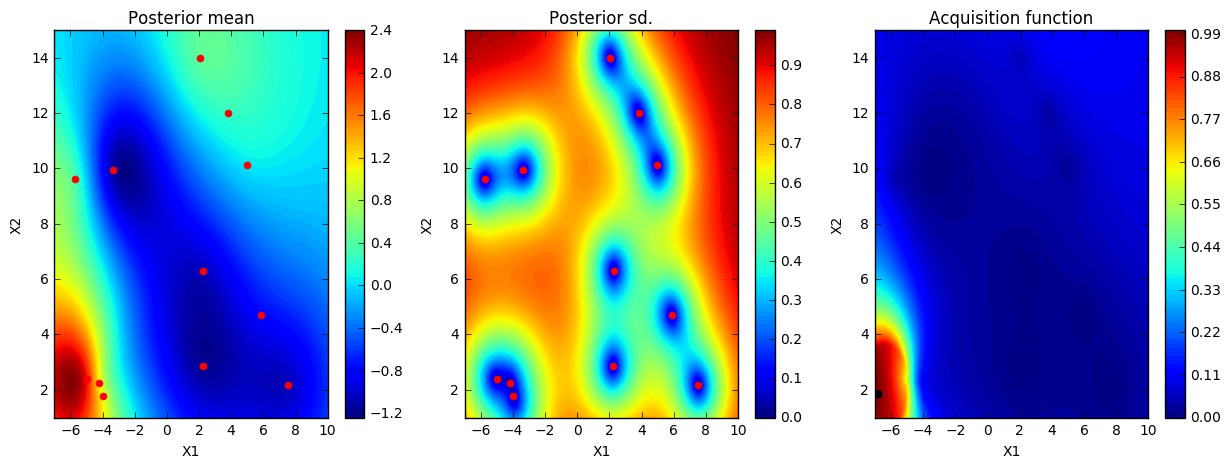

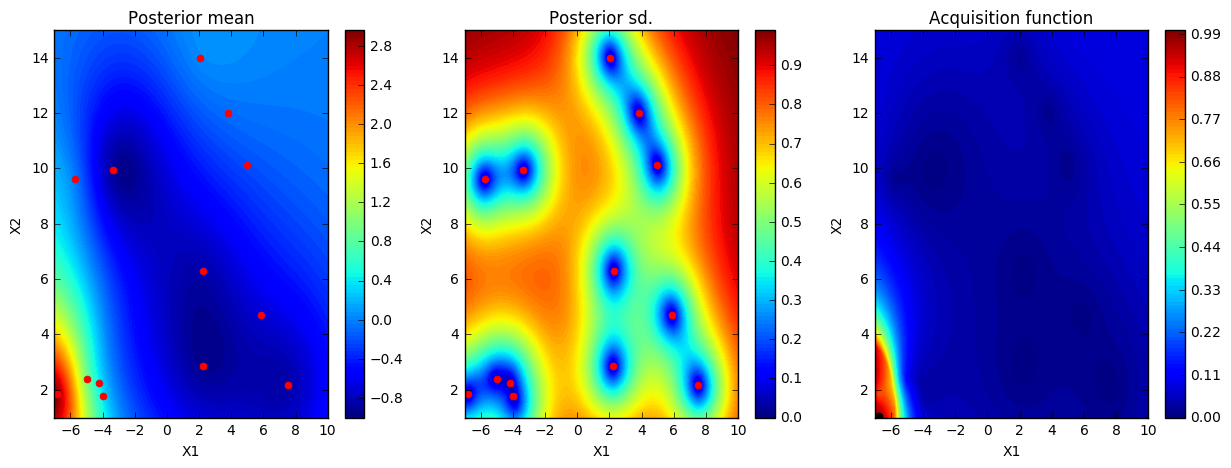

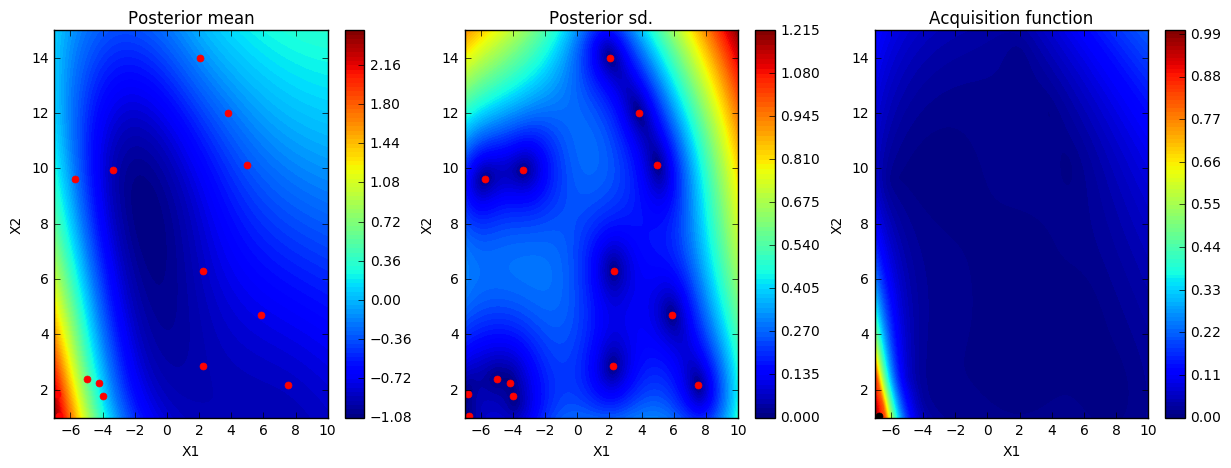

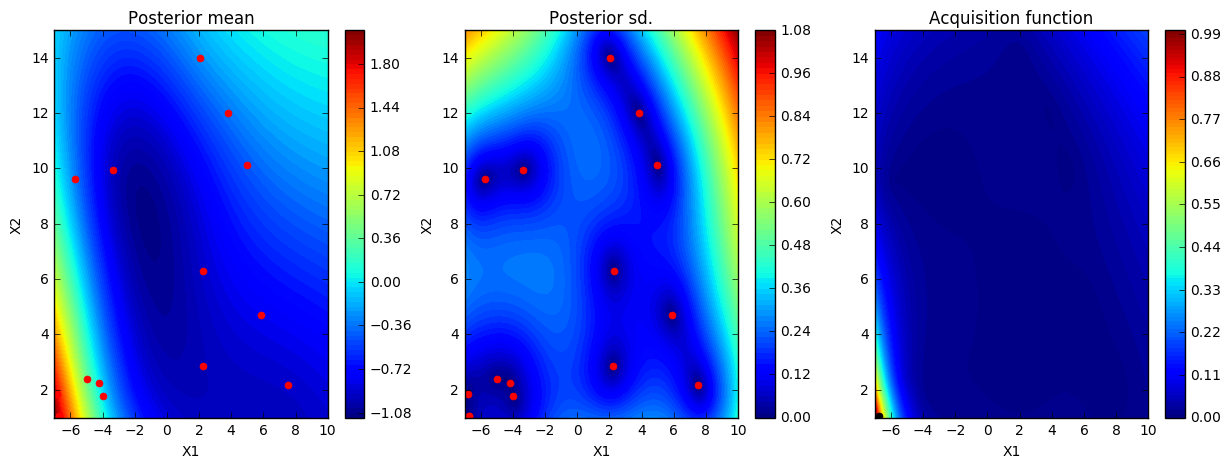

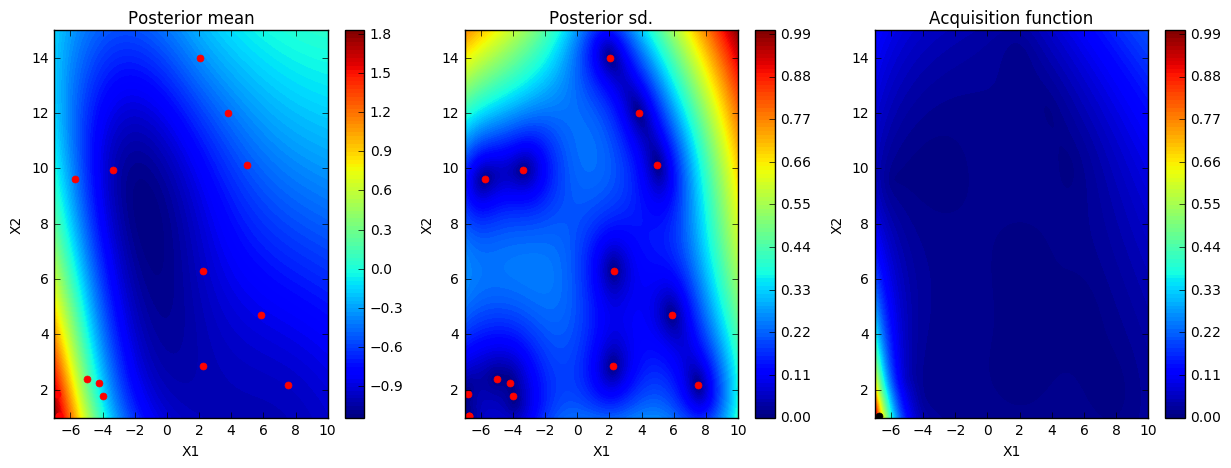

In [212]:
func  = GPyOpt.objective_examples.experiments2d.branin()
objective = GPyOpt.core.task.SingleObjective(func.f)
space = GPyOpt.Design_space(space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-7,10)},
                                    {'name': 'var_2', 'type': 'continuous', 'domain': (1,15)}])
# model = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model = GPyOpt.models.GPModel(kernel=___,optimize_restarts=5,verbose=False)
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space, fast=True, n_samples=1000, maxiter=10)
initial_design = GPyOpt.util.stats.initial_design('random', space, 10)
acquisition = AcquisitionEIMasked(model, space, optimizer=aquisition_optimizer)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
bo = GPyOpt.methods.ModularBayesianOptimization(model, space, objective, acquisition, evaluator, initial_design)
max_iter  = 2
bo.run_optimization(max_iter = max_iter, eps=-1)

# TODO: global bo, modular pieces within gp_model.py

for i in range(0,5):
#     TODO: This section should be in compute_controls function ***
    bo.max_iter = 1
    bo.max_time = np.inf
#     if bo.X is not None and bo.Y is None:
#         bo.Y, cost_values = bo.objective.evaluate(bo.X)
    bo.suggested_sample = bo.X
    bo.Y_new = bo.Y
#     DOES NOT update bo.x,bo.y -- just the GP model gets optimized
    print "before: ", bo.model.model.kern.lengthscale
    bo._update_model()
    print "after: ", bo.model.model.kern.lengthscale
    bo.suggested_sample = bo._compute_next_evaluations()
#     ***

    bo.X = np.vstack((bo.X,bo.suggested_sample))
#     TODO: this step rewritten to update with results from simulation
    bo.evaluate_objective()
    bo.plot_acquisition()


In [216]:
print model.model.kern.output_dim

AttributeError: 'Matern32' object has no attribute 'output_dim'

In [29]:
from pylab import grid
import matplotlib.pyplot as plt
from pylab import savefig
import pylab


def plot_acquisition(bounds,input_dim,model,Xdata,Ydata,acquisition_function,suggested_sample, filename = None):
    if input_dim ==2:
        X1 = np.linspace(bounds[0][0], bounds[0][1], 200)
        X2 = np.linspace(bounds[1][0], bounds[1][1], 200)
        x1, x2 = np.meshgrid(X1, X2)
        X = np.hstack((x1.reshape(200*200,1),x2.reshape(200*200,1)))
        acqu = acquisition_function(X)
        acqu_normalized = (-acqu - min(-acqu))/(max(-acqu - min(-acqu)))
        acqu_normalized = acqu_normalized.reshape((200,200))
        m, v = model.predict(X) 
        plt.figure(figsize=(15,5))
        plt.subplot(1, 3, 1)
        plt.contourf(X1, X2, m.reshape(200,200),100)
        plt.plot(Xdata[:,0], Xdata[:,1], 'r.', markersize=10, label=u'Observations')
        plt.colorbar()
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.title('Posterior mean')
        plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
        ##
        plt.subplot(1, 3, 2)
        plt.plot(Xdata[:,0], Xdata[:,1], 'r.', markersize=10, label=u'Observations')
        plt.contourf(X1, X2, np.sqrt(v.reshape(200,200)),100)
        plt.colorbar()
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.title('Posterior sd.')
        plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
        ##
        plt.subplot(1, 3, 3)
        plt.contourf(X1, X2, acqu_normalized,100)
        plt.colorbar()
        plt.plot(suggested_sample[:,0],suggested_sample[:,1],'k.', markersize=10)
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.title('Acquisition function')
        plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
        
        return X, acqu
            
            

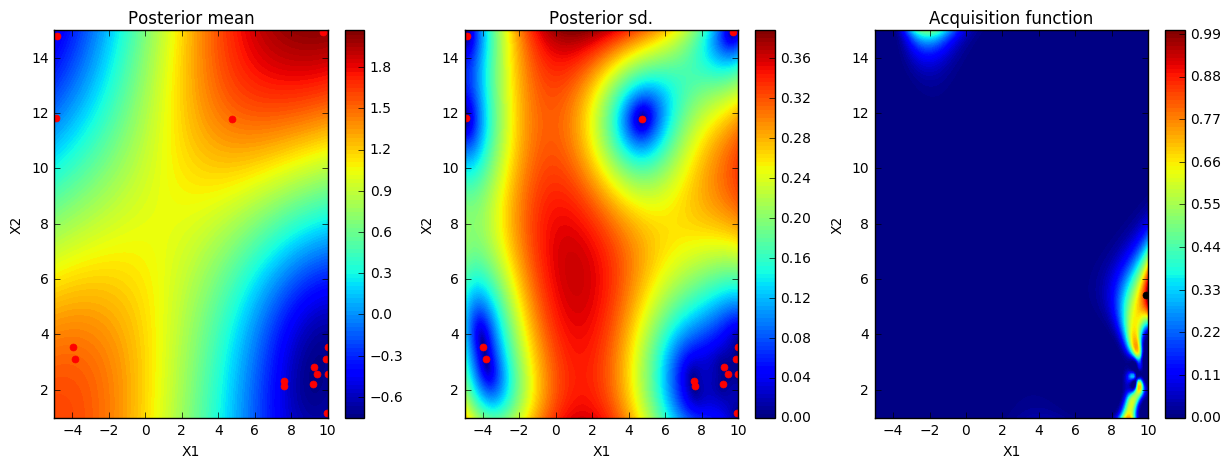

In [30]:
X, acq = plot_acquisition(bo.acquisition.space.get_bounds(),
                                bo.model.model.X.shape[1],
                                bo.model.model,
                                bo.model.model.X,
                                bo.model.model.Y,
                                bo.acquisition.acquisition_function,
                                bo.suggested_sample,
                                None)


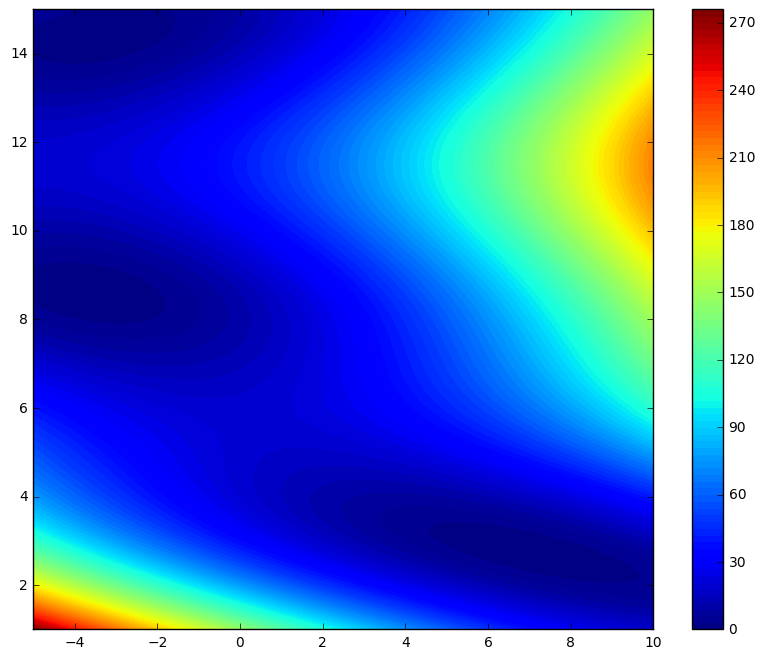

In [97]:
X1 = np.linspace(-5, 10, 200).reshape((200,1))
X2 = np.linspace(1, 15, 200).reshape((200,1))
X = []
for x in X1:
    for y in X2:
        X.append(np.array([x[0],y[0]]))
X = np.array(X)
X1 = np.linspace(-5, 10, 200)
X2 = np.linspace(1, 15, 200)
fig = plt.figure(figsize=(10,8))
plt.contourf(X1, X2, func.f(X).reshape(200,200),100)
plt.colorbar()
plt.show()